In [13]:
from tensorflow.keras.layers import Embedding, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import optimizers
from nltk import word_tokenize
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import gensim
import numpy as np
import pandas as pd 
import seaborn as sn
import os
import io
import pickle
import random
import itertools
from importnb import Notebook, reload
with Notebook(): 
    import Utilities

In [2]:
def preprocess_text(df):
    """ Tokenize """
    conc = pd.DataFrame()
    for i in set(df.index):
        concat_str = ''
        for title in df.loc[i]['title']:
            concat_str += " " + title.lower()
        concat_str = word_tokenize(concat_str)
        conc = conc.append({'date':i, 'title':concat_str},ignore_index=True)
    conc.set_index('date',inplace=True)
    conc = conc.sort_values('date')
    return conc

def title2vec(data, emb_dict,index): 
    """Embed a title with an arbitrary number of words to a vector 
     with shape(d), where d is the dimension of the embedding. """
    d = 300
    x = np.zeros((len(data), d))
    for i,row in enumerate(data.values): 
        n = 0
        temp = np.zeros(d)
        for word in row[0]: 
            if word in emb_dict.keys(): 
                n += 1
                temp = np.add(temp, emb_dict.get(word))
        x[i] = temp / n
    return x

In [3]:
# Specify the path to OneDrive
ONEDRIVE_PATH = Path(r"C:\Users\gusta\Kidbrooke Advisory Ab\KidbrookeOneDrive - Gustaf Backman exjobb")

config = {
    'start_date': '2006-10-20',
    'end_date': '2013-11-19',
    'lookback': 5,       # Using lookback > 1 is not yet implemented
    'delay': 3,
    'p': 1,
    'd': 1,
    'q': 1,
    'series': '1 YEAR',
}

In [4]:
# Load data 
news_path = ONEDRIVE_PATH / "Input Data/financial_headlines_20061020-20131119.pkl"
news_data = pd.DataFrame(pd.read_pickle(news_path))
news_data.set_index('date',inplace=True)
# Tokenize
data = preprocess_text(news_data)

In [5]:
# Load dictionary of embeddings for this vocabulary (previously constructed)
subset_embeddings = ONEDRIVE_PATH / "Embeddings/GloVe/saved.42B.300d.pkl"
with open(subset_embeddings,'rb') as handle: 
    emb_dict = pickle.load(handle)

In [6]:
# Create an index mapping for all words in the vocabulary
word_index = {}
i = 1
for word in emb_dict.keys(): 
    word_index.update({word:i})
    i += 1

In [7]:
unique_words = set() 
for title in data['title']:
    for word in title: 
        unique_words.add(word)
print("Total vocabulary size:",len(unique_words))
print("Words not included in GloVe:",len(unique_words) - len(emb_dict))


Total vocabulary size: 29083
Words not included in GloVe: 2850


In [8]:
# Transform the data to the average word embedding each day
x = title2vec(data,emb_dict,word_index)

# Load the label data
y = Utilities.load_direction_labels(config)

# Remove last row of the x-matrix, since there's no label for that entry
if x.shape[0] != len(y): 
    x = x[:-1]

In [9]:
(x_train,y_train), (x_test, y_test) = Utilities.shuffle_and_partition(x,y, test_part=0.2)
print("Shape of x_train: ",x_train.shape)
print("Shape of y_train: ",y_train.shape)

Shape of x_train:  (2064, 300)
Shape of y_train:  (2064,)


In [69]:
def print_test_data(y_test, y_test_pred): 
    conf_mat = confusion_matrix(y_test,y_test_pred,normalize='pred')
    ax = sn.heatmap(conf_mat,)
    ax.set_ylabel("True values")
    ax.set_xlabel("Predicted values")
    plt.show()
    y_sums = np.zeros(2)
    y_sums[0] = sum(y_test_pred == 0)
    y_sums[1] = sum(y_test_pred == 1)
    plt.bar([0,1],y_sums,label='Number of preds')
    plt.xticks([0,1])
    plt.legend()
    plt.show()
    y_train_sums = np.zeros(2)
    y_train_sums[0] = sum(y_train == 0)
    y_train_sums[1] = sum(y_train == 1)
    plt.bar([0,1],y_train_sums,label='Distribution in train data')
    plt.xticks([0,1])
    plt.legend()
    plt.show()
    print(classification_report(y_test, y_test_pred))

In [70]:
# Random forest classifier
rf_model = RandomForestClassifier(n_estimators=1000)
rf_model.fit(x_train,y_train)
y_test_pred = rf_model.predict(x_test)

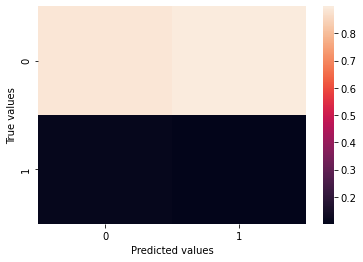

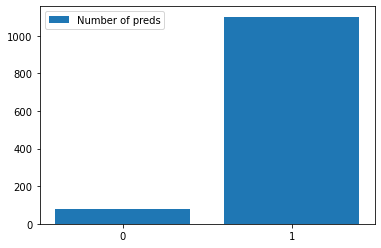

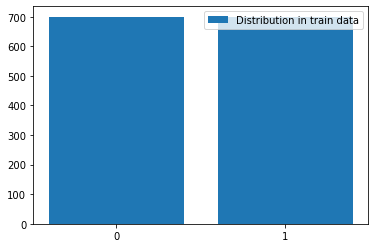

              precision    recall  f1-score   support

         0.0       0.89      0.07      0.12      1061
         1.0       0.10      0.93      0.18       120

    accuracy                           0.15      1181
   macro avg       0.49      0.50      0.15      1181
weighted avg       0.81      0.15      0.13      1181



In [71]:
print_test_data(y_test, y_test_pred)

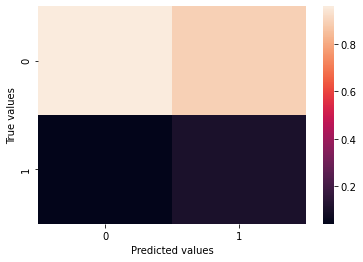

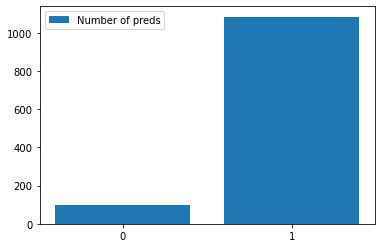

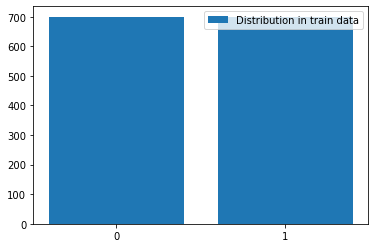

              precision    recall  f1-score   support

         0.0       0.96      0.09      0.16      1061
         1.0       0.11      0.97      0.19       120

    accuracy                           0.18      1181
   macro avg       0.53      0.53      0.18      1181
weighted avg       0.87      0.18      0.16      1181



In [72]:
# XGBoost classifier
xgb_model = XGBClassifier()
xgb_model.fit(x_train,y_train)
y_test_pred = xgb_model.predict(x_test)
print_test_data(y_test, y_test_pred)